# Eploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
df = pd.read_csv("final_df.csv", parse_dates = ["Date"], low_memory = False )
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

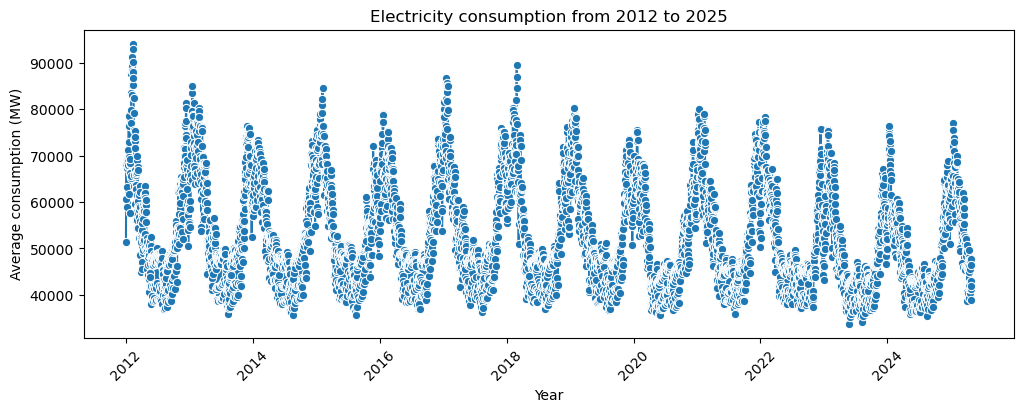

In [3]:
## Variation in consumption from 2012 to 2025 ##

df_daily = (
    df['Consommation']
      .resample('D')     # 'D' for 'day'
      .mean()
      .dropna()
)

plt.figure(figsize = (12,4))
sns.lineplot(x = df_daily.index, y=  df_daily.values, marker='o')
plt.xticks(rotation = 45)
plt.title("Electricity consumption from 2012 to 2025")
plt.ylabel("Average consumption (MW)")
plt.xlabel("Year")
plt.show()

**Analyse** : 
- Effet important de la saisonalité : la consommation augmente en hiver et chute en été.
- Le profil de consommation se repète année après année sans changement notable.

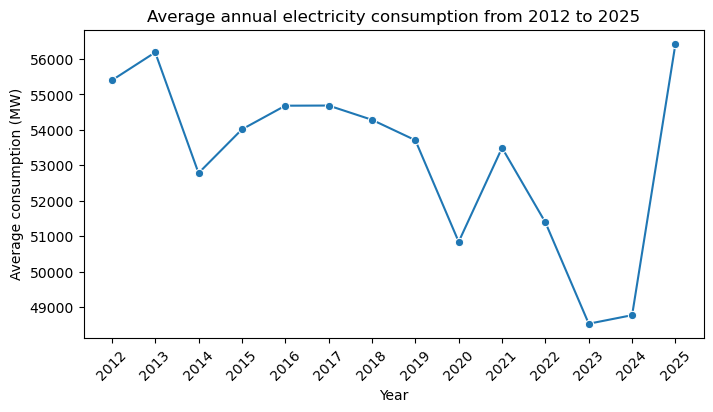

In [4]:
## Variation in mean annually consumption ##

df_daily = (
    df['Consommation']
      .resample('D')     # 'D' for 'day'
      .mean()
      .dropna()
)

df_annual = df_daily.resample('YE').mean()
df_annual.index = df_annual.index.year

plt.figure(figsize = (8,4))
sns.lineplot(x = df_annual.index, y = df_annual.values, marker = 'o')
plt.xticks(df_annual.index, rotation = 45)
plt.title("Average annual electricity consumption from 2012 to 2025")
plt.ylabel("Average consumption (MW)")
plt.xlabel("Year")
plt.show()

**Analyse** : 
- Est-ce l'impact du covid que l'on observe entre 2019 et 2021 ?
- Comment expliquer le creux important entre 2023 et 2024 ? Cela est du au changement de régimes entre fin 2022 (mesure de consomation toutes les 30 minutes) et début 2023 (mesure de consomation toutes les 15 minutes)

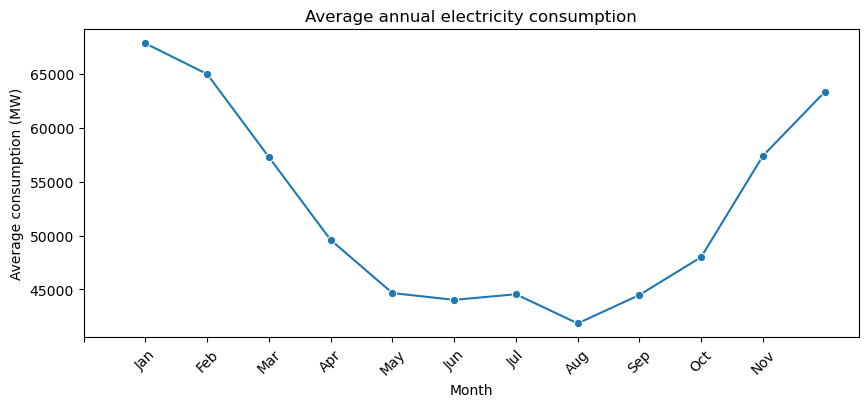

In [5]:
## Mean variation in consumption in one year ##

months = df.index.month
df['month'] = months
avg_by_month = df.groupby('month')['Consommation'].mean()
plt.figure(figsize = (10,4))
sns.lineplot(x = avg_by_month.index, y = avg_by_month.values, marker='o')
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks = range(1,13), labels = month_labels, rotation = 45)
plt.title("Average annual electricity consumption")
plt.ylabel("Average consumption (MW)")
plt.xlabel("Month")
plt.xticks(range(0,12))
plt.show()

**Analyse** : Effet important de la saisonalité : la consommation augmente en hivers et chute en été.

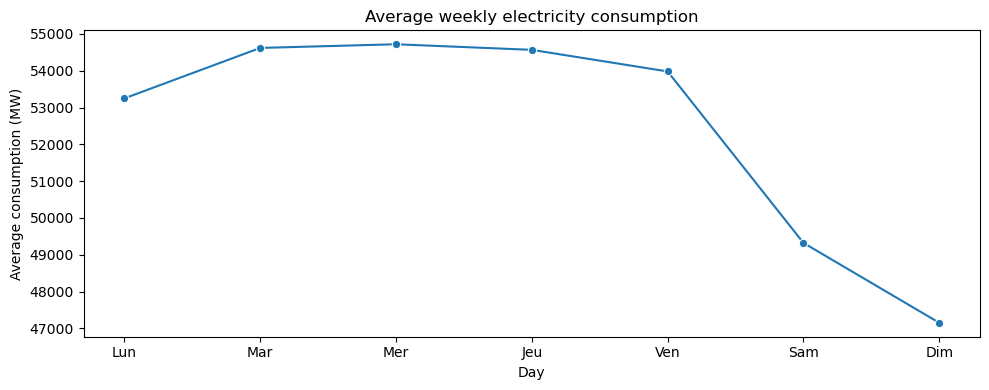

In [6]:
## Mean variation in consumption in one week ##

df['weekday'] = df.index.weekday
avg_by_weekday = df.groupby('weekday')['Consommation'].mean()

plt.figure(figsize = (10,4))
sns.lineplot(x = avg_by_weekday.index, y = avg_by_weekday.values, marker = 'o')
weekday_labels = ['Lun','Mar','Mer','Jeu','Ven','Sam','Dim']
plt.xticks(ticks=  range(7), labels = weekday_labels)
plt.title("Average weekly electricity consumption")
plt.ylabel("Average consumption (MW)")
plt.xlabel("Day")
plt.tight_layout()
plt.show()

**Analyse** : Effet important du jour de la semaine : la consommation augmente la semaine, lorsque l'activité humaine bat son plein, et retombe le week-end.

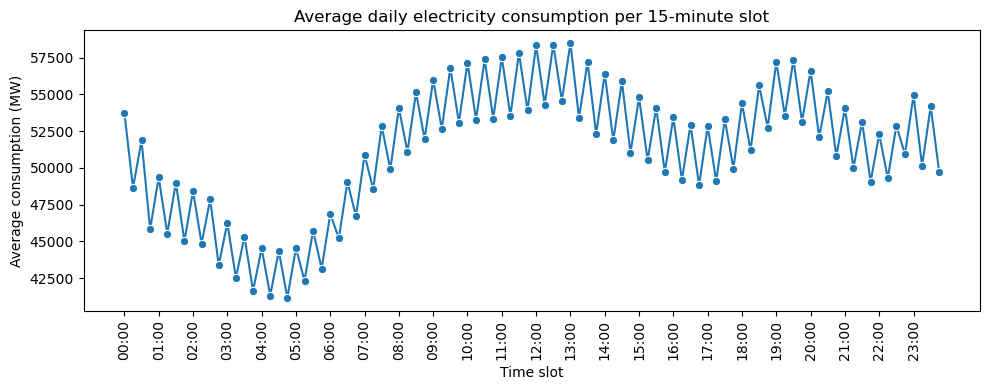

In [7]:
## Mean variation in consumption on one day ##

df_q = df.dropna(subset=['Consommation'])

avg_by_slot = (
    df_q.groupby('Heures')['Consommation']
        .mean()
        .reindex(sorted(df_q['Heures'].unique()))
)

plt.figure(figsize=(10,4))
sns.lineplot(x = avg_by_slot.index, y = avg_by_slot.values, marker='o')
hour_ticks = list(range(0, len(avg_by_slot), 4))
hour_labels = [avg_by_slot.index[i] for i in hour_ticks]
plt.xticks(ticks = hour_ticks, labels = hour_labels, rotation = 90)
plt.title("Average daily electricity consumption per 15-minute slot")
plt.xlabel("Time slot")
plt.ylabel("Average consumption (MW)")
plt.tight_layout()
plt.show()

**Analyse** :
* Effet important de l'heure : la consommation augmente en journée lorsque l'activité humaine bat son plein, et retombe la nuit.
* Le "cisaillement" est probablement du au fait que si les heures sont divisées en quart d'heure dans le DataFrame, il n'y a que deux mesures de consommations par heures (minute 00 et minute 30). Il faudra supprime ces lignes.

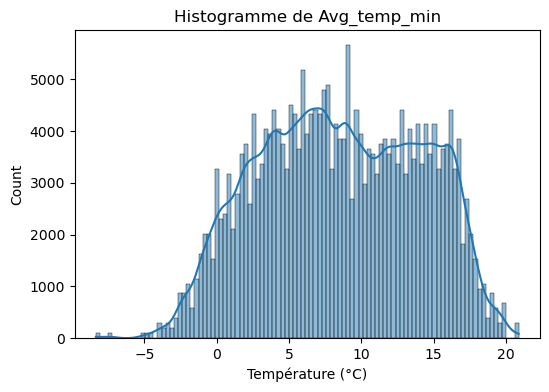

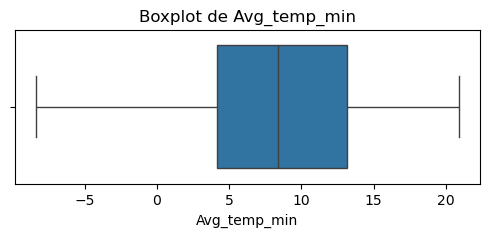

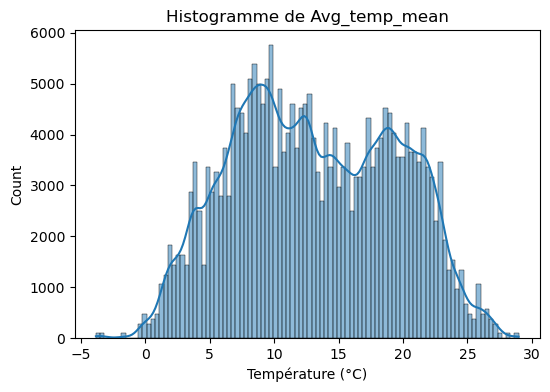

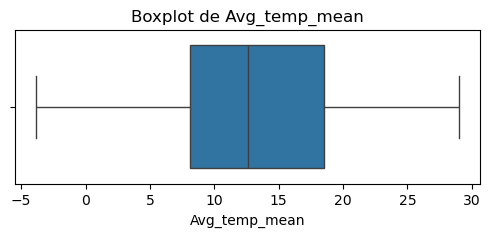

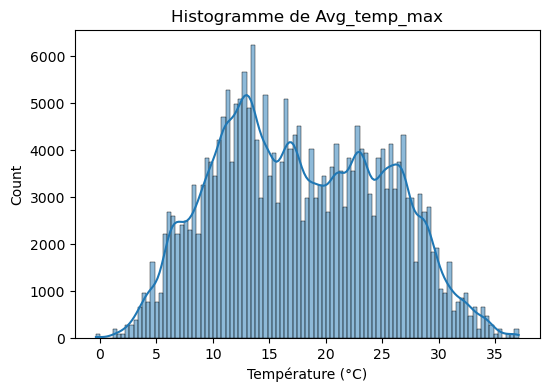

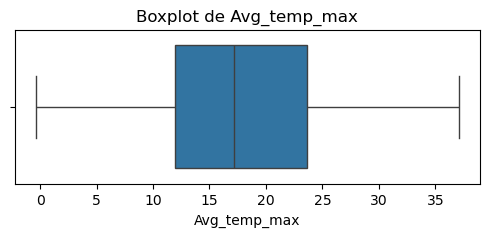

In [8]:
## Temperature histograms and boxplots ##

temp_cols = ['Avg_temp_min','Avg_temp_mean','Avg_temp_max']
for col in temp_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Histogramme de {col}")
    plt.xlabel("Température (°C)")
    plt.show()

    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot de {col}")
    plt.show()

**Analyse** :
* On observe plusieurs bosses pour chaque histograme, signe que la température suit non pas une distribution normale, mais, multimodale qui reflete les saisons.
* On a un pic pour les températures basses (hiver), un autre pour les températures élevées (été), et parfois un autre au printemps/automne ?

Correlation Consumption vs Avg_temp_mean : -0.7578605257517298


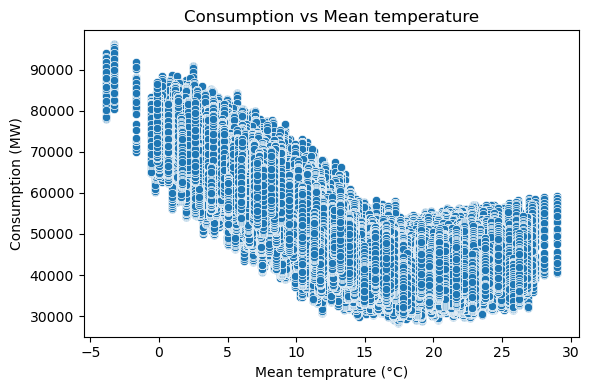

In [9]:
## Correlation between consumption and average temperature ##

print("Correlation Consumption vs Avg_temp_mean :", df['Consommation'].corr(df['Avg_temp_mean']))

# Scatter plot consumption vs temperature

df_q = df.dropna(subset = ['Avg_temp_mean','Consommation'])

plt.figure(figsize = (6,4))
sns.scatterplot(
    data = df_q, 
    x = 'Avg_temp_mean', 
    y = 'Consommation'
)
plt.title("Consumption vs Mean temperature")
plt.xlabel("Mean temprature (°C)")
plt.ylabel("Consumption (MW)")
plt.tight_layout()
plt.show()

**Analyse** :

Forte corrélation négative avec la température : –0,76

Quand la température moyenne nationale dilinue, la consommation électrique augmente de façon assez linéaire, car en hiver, les besoins de chauffage explosent. Inversement pour l'été.


In [10]:
## Correlation betwen consumption and weekdays, week-end, vacation and blank-holidays ##

# Create weekday/weekend/holiday variables

if 'Bank holidays' in df.columns:
    df['is_bank_holiday'] = df['Bank holidays']
if 'School holidays' in df.columns:
    df['is_school_hol'] = df['School holidays']
df['weekday'] = df.index.weekday
df['is_weekend'] = df['weekday'] >= 5

# Average comparison

print("Weekdays mean consumption vs Weekend mean consumption :")
print(df.groupby('is_weekend')['Consommation'].mean())
print("Vacation mean consumption vs Non-vacation mean consumption :")
print(df.groupby('is_school_hol')['Consommation'].mean())
print("Bank holidays mean consumption vs Classic days mean consumption :")
print(df.groupby('is_bank_holiday')['Consommation'].mean())

Weekdays mean consumption vs Weekend mean consumption :
is_weekend
False    54227.943835
True     48237.418256
Name: Consommation, dtype: float64
Vacation mean consumption vs Non-vacation mean consumption :
is_school_hol
False    53937.467216
True     50550.354254
Name: Consommation, dtype: float64
Bank holidays mean consumption vs Classic days mean consumption :
is_bank_holiday
False    52741.357055
True     45114.302703
Name: Consommation, dtype: float64


**Analyse** :

*Effet week-end vs semaine*

* Moyenne en semaine ≃ 54 228 MW
* Moyenne le week-end ≃ 48 237 MW

-> En moyenne, la consommation le week-end est ~11 % plus basse qu’en semaine.

-> Pourquoi ? Moins d’activité industrielle et tertiaire le week-end, plus de foyers inoccupés (?) ou en activité domestique (qui consomme moins qu’une usine).

*Impact des vacances scolaires*

* Jours hors vacances ≃ 53 937 MW
* Jours de vacances ≃ 50 550 MW

-> En moyenne, la consommation durant les vacances est ~6 % plus basses que le reste du temps.

-> Pourquoi ? Fermeture partielle des écoles et des bureaux, moindre activité économique, etc.

*Impact des jours fériés*

* Jours classiques ≃ 52 741 MW
* Jours fériés ≃ 45 114 MW

-> Chute spectaculaire (~15 %) de la demande lors des jours fériés !

-> Pourquoi ? Presque toute l’industrie et les services sont à l’arrêt, seuls les usages domestiques persistent.

In [11]:
##  Average proportion of BLUE, WHITE, RED days per year  ##

order = ['BLEU','BLANC','ROUGE']
df['year'] = df.index.year

df_days = df.dropna(subset = ['Type de jour TEMPO']).copy()
df_days['Type de jour TEMPO'] = pd.Categorical(df_days['Type de jour TEMPO'], categories = order)

counts = df_days.groupby(['year','Type de jour TEMPO']).size().unstack(fill_value = 0)
props = counts.div(counts.sum(axis = 1), axis = 0)
mean_props = props.mean()

print("Average proportion of days per TEMPO index over the years :")
print(mean_props)

Average proportion of days per TEMPO index over the years :
Type de jour TEMPO
BLEU     0.810511
BLANC    0.126853
ROUGE    0.062637
dtype: float64


D:\TEMP\ipykernel_28056\997856821.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_days.groupby(['year','Type de jour TEMPO']).size().unstack(fill_value = 0)


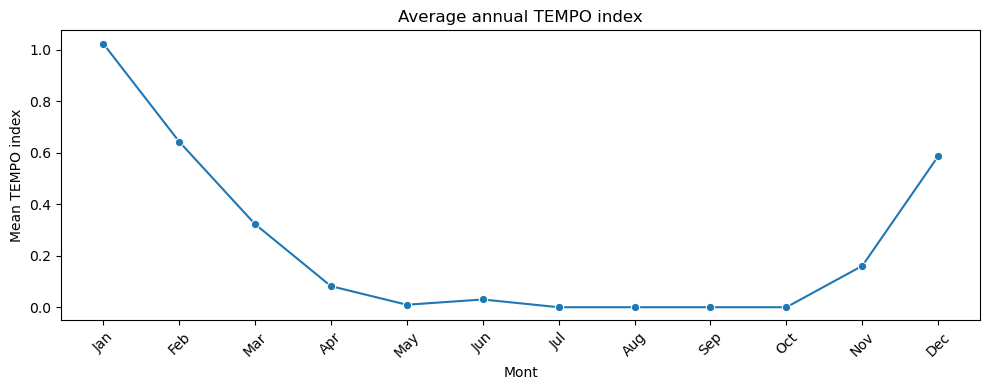

In [12]:
# TEMPO index over time

tempo_map = {'BLEU':0, 'BLANC':1, 'ROUGE':2}
df['tempo_idx'] = df['Type de jour TEMPO'].map(tempo_map)

df['month'] = df.index.month
avg_tempo_all_years = df.groupby('month')['tempo_idx'].mean()

plt.figure(figsize=(10,4))
sns.lineplot(x=avg_tempo_all_years.index, y=avg_tempo_all_years.values, marker='o')
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(1,13), labels=month_names, rotation=45)
plt.title("Average annual TEMPO index")
plt.xlabel("Mont")
plt.ylabel("Mean TEMPO index")
plt.tight_layout()
plt.show()

**Analyse**:

Code :
* BLEU = 0
* BLANC = 1
* ROUGE = 2

Interprétation :
* Ordonnée proche de 0 → quasi-exclusivement des jours BLEU (tarif le plus bas).
* Ordonnée ≈ 1 → mix de jours BLEU et BLANC (tarif moyen).
* Ordonnée > 1 → présence non négligeable de jours ROUGE (tarif le plus élevé). Il y a beaucoup moins de jours ROUGES (6%) que BLEU (81%) ou BLANC (12%), ce qui explique pourquoi 1 est à peine dépassé.

-> Le prix est haut en hiver et bas en été.

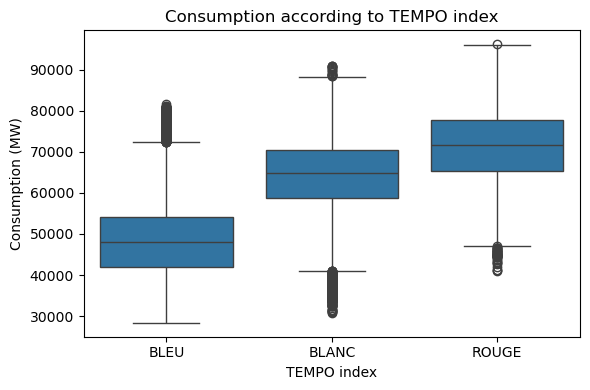

In [13]:
## Interaction Consommation vs TEMPO ##

order = ['BLEU','BLANC','ROUGE']
df_box = df.dropna(subset = ['Consommation','Type de jour TEMPO'])
df_box = df_box[df_box['Type de jour TEMPO'].isin(order)]

df_box['Type de jour TEMPO'] = pd.Categorical(df_box['Type de jour TEMPO'], categories = order, ordered = True)

plt.figure(figsize=(6,4))
sns.boxplot(x = 'Type de jour TEMPO', y = 'Consommation',  data = df_box,  order = order)
plt.title("Consumption according to TEMPO index")
plt.xlabel("TEMPO index")
plt.ylabel("Consumption (MW)")
plt.tight_layout()
plt.show()

**Analyse**:

* BLEU < BLANC < ROUGE : le tarif TEMPO est justement calibré pour être plus élevé les jours où la demande (consommation) est forte.
* L’IQR s’élargit de BLEU à ROUGE : les jours “Rouge” voient non seulement une plus haute consommation moyenne, mais aussi des fluctuations plus marquées (pics plus fréquents).
  
-> Le découpage TEMPO capte très bien les régimes de basse,  moyenne et haute demande.


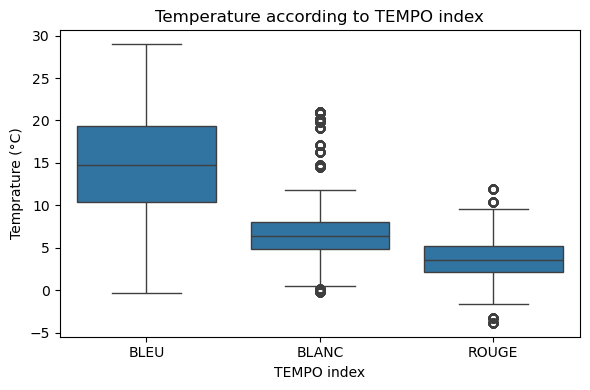

In [14]:
## Interaction Température vs TEMPO ##

order = ['BLEU','BLANC','ROUGE']
df_temp = df.dropna(subset = ['Avg_temp_mean','Type de jour TEMPO'])
df_temp = df_temp[df_temp['Type de jour TEMPO'].isin(order)]

df_temp['Type de jour TEMPO'] = pd.Categorical(df_temp['Type de jour TEMPO'],categories=  order,ordered=True)

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x='Type de jour TEMPO',y= 'Avg_temp_mean',data = df_temp,order = order
)
plt.title("Temperature according to TEMPO index")
plt.xlabel("TEMPO index")
plt.ylabel("Temprature (°C)")
plt.tight_layout()
plt.show()

**Analyse**:

* Plus l’indice passe de Bleu → Blanc → Rouge, plus la température médiane décroit.
* Les jours bleus couvrent un spectre très large (0–29 °C).
* Quelques journées atypiques : Des journées très chaudes classées « Blanc » (pic solaire, vent, incidents réseau ?), des journées très froides à 0°C où l’indice reste « Blanc » (mauvais prévisions ?), etc ?

-> TEMPO synthétise très bien l’effet thermique : les jours rouges sont typiquement les plus froids, les jours bleus les plus doux ou chauds.

## Conclusion

Les variables suivantes expliquent une part importante de la variabilité :

* La température (et donc les saisons).

* L'heure de la journée.

* Le type de jour (semaine/week-end).

* Les vacances et les jours fériés.

* Les jours TEMPO.

## Pour aller plus loin

* Tester la significativité statistique (p-values) de ces effets 
* Visualiser les interactions (ex. consommation vs température séparée week-end / semaine).
